This training run is done on the new dataset with 1830 airfoils, 1 mach #, 25 AoA #s, and 3 Re #s.

It runs on the redefined NIF model. Retraining the entire model again, but with normalization on the Reynolds column.

In [11]:
%load_ext autoreload
%autoreload 2

# Define autroreload so that it doesn't cause pain in the ass when we change the functions and run this notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Import all the models, training functions, manipulators here

# Define the relative paths, append it to the system path
import sys
from pathlib import Path
project_root = Path.cwd().resolve().parents[4]
github_root = Path.cwd().resolve().parents[3]
sys.path.append(str(project_root))
sys.path.append(str(github_root))

print(project_root)
print(github_root)

# Import shenanigans
from defs.helper_functions.training_functions import *
from defs.helper_functions.data_loaders import *
from defs.models.NIF import *

# Time, to precisely: time
import time

C:\SenkDosya\Projects\AeroML
C:\SenkDosya\Projects\AeroML\initial-project


In [13]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")  # Force CPU for testing purposes
print(f"Using device: {device}")

Using device: cuda


In [14]:
# Figure out the data
df = pd.read_csv(rf"C:\SenkDosya\Projects\AeroML\airfoil_data\airfoil_dataset_8bern.csv")

df = df.drop(['N1', 'N2'], axis=1) # Remove N1 and N2 since all the airfoils are subsonic

df['Reynolds'] = df['Reynolds'] / 1000000 # Normalize the Reynolds feature, too dominant

print(df.head)

geom, cond, perf, names= get_dataset(df, loc_geometry=[1,20], loc_cond=[21,23], loc_perf_coeffs=[24,26], loc_names=0) # Get the necessary stuff for the dataset
print(df.shape); print(geom.shape); print(cond.shape); print(perf.shape); print(len(names))

ds = AirfoilDataset(geom, cond, perf, names)

del df, geom, cond, perf, names # Delete these to preserve memory

cfg_loader = {
    'n_epoch': 100,
    'n_train': 1000,
    'n_test': 17250,
    'train_batch': 1
}

dl_train, dl_val, dl_test = get_dataloaders(ds=ds, cfg_loader=cfg_loader)


<bound method NDFrame.head of         airfoil_name      Bu_0      Bu_1      Bu_2      Bu_3      Bu_4  \
0       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
1       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
2       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
3       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
4       airfoil_0001  0.273636 -0.200785  1.229138 -1.445725  1.790261   
...              ...       ...       ...       ...       ...       ...   
137245  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137246  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137247  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137248  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   
137249  airfoil_1830  0.327410  1.499799 -0.780311  3.149627 -1.415475   

            Bu_5      Bu_6      Bu_7     Bu_8  ...      Bl_7      Bl_8  \
0      

In [15]:
import torch.nn as nn

# Define the model and optimizer

cfg_shape_net = {
    'input_dim': 20,
    'output_dim': 3,
    'hidden_units': [2048,2048,2048,2048,2048],
    'shape_activation': nn.SELU
}

cfg_param_net = {
    'input_dim': 3,
    'hidden_units': [512,512,512],
    'param_activation': nn.Tanh
}

model = NIF_Pointwise(cfg_shape_net=cfg_shape_net, cfg_param_net=cfg_param_net)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

model = model.to(device)

# Define the loss_fn

loss_fn = nn.MSELoss()

In [16]:
# Show the model

from torchviz import make_dot

# Create and move inputs to device
show_tensor_1 = torch.randn(5, cfg_shape_net['input_dim']).to(device)
show_tensor_2 = torch.randn(5, cfg_param_net['input_dim']).to(device)

# Forward pass
output = model(show_tensor_1, show_tensor_2)

make_dot(output, params=dict(model.named_parameters())).render("model_graph_pairnif2", format="png")

'model_graph_pairnif2.png'

In [17]:
# Train the model

# Define the configs of train
cfg_train = {
    'cfg_loader': cfg_loader,
    'dtype': torch.float32,
    'device': device
}

dataloaders = [dl_train, dl_val, dl_test]


collector_dict, model = train(cfg_train=cfg_train, model=model, optimizer=optimizer, loss_fn=loss_fn, dataloaders=dataloaders)

Epoch 1 | Train run 1 loss: 1.3203184604644775
Epoch 1 | Train run 2 loss: 0.07874578982591629
Epoch 1 | Train run 3 loss: 0.9607476592063904
Epoch 1 | Train run 4 loss: 0.20130184292793274
Epoch 1 | Train run 5 loss: 0.965178370475769
Epoch 1 | Train run 6 loss: 0.5692254304885864
Epoch 1 | Train run 7 loss: 0.9212531447410583
Epoch 1 | Train run 8 loss: 0.7899702787399292
Epoch 1 | Train run 9 loss: 0.04104314744472504
Epoch 1 | Train run 10 loss: 0.026065176352858543
Epoch 1 | Train run 11 loss: 0.10317707061767578
Epoch 1 | Train run 12 loss: 0.8631125688552856
Epoch 1 | Train run 13 loss: 1.2658793926239014
Epoch 1 | Train run 14 loss: 0.9617304801940918
Epoch 1 | Train run 15 loss: 0.021329499781131744
Epoch 1 | Train run 16 loss: 0.44856393337249756
Epoch 1 | Train run 17 loss: 0.08218704164028168
Epoch 1 | Train run 18 loss: 0.019393963739275932
Epoch 1 | Train run 19 loss: 0.03504012152552605
Epoch 1 | Train run 20 loss: 0.1976214349269867
Epoch 1 | Train run 21 loss: 0.060329

torch.Size([100000])
100000


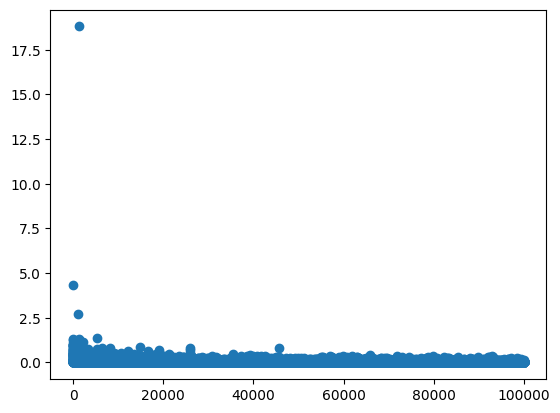

In [18]:
print(collector_dict['losses']['train'].shape)
import numpy as np


train_losses = collector_dict['losses']['train'].numpy()
index= np.arange(100000)

print(train_losses.size)

import matplotlib.pyplot as plt

plt.scatter(index, train_losses, )
plt.show()

[0.0506633  0.04785276 0.04130844 0.03403123 0.02834935 0.03841666
 0.03077577 0.02669836 0.02164764 0.01739519 0.02319201 0.02028874
 0.01292119 0.01537949 0.02510888 0.01883382 0.02001989 0.01304209
 0.01617227 0.02626551 0.01748944 0.01096548 0.00887299 0.01079034
 0.01761437 0.02677616 0.00856312 0.0157389  0.01106321 0.01223252
 0.01984033 0.00697134 0.0098734  0.02570173 0.00759268 0.0078927
 0.01038484 0.00833473 0.01268808 0.00912766 0.00584752 0.00692901
 0.00712692 0.00857183 0.01031256 0.00981381 0.01082132 0.01248764
 0.00560506 0.00583055 0.00721276 0.00545353 0.00628816 0.00675788
 0.00690574 0.00652579 0.00589886 0.00787945 0.00559068 0.00774958
 0.00750131 0.00545493 0.00827235 0.00933907 0.00926499 0.01885203
 0.00733623 0.00436306 0.00861858 0.00642456 0.00455369 0.00521431
 0.00660244 0.00679794 0.00542131 0.01598283 0.0080668  0.00761459
 0.01145936 0.0054801  0.00529603 0.0067209  0.0069259  0.00851905
 0.00499672 0.00653292 0.00929501 0.00479862 0.01024514 0.00615

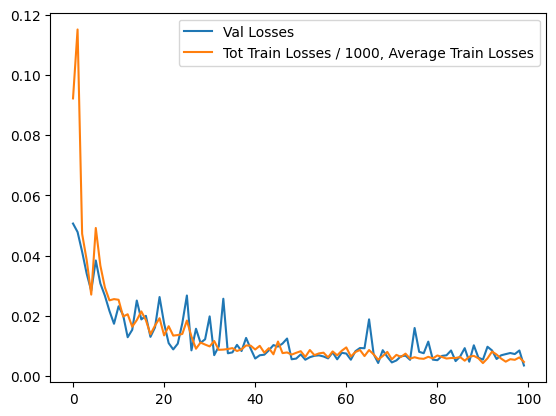

In [19]:
tot_train_losses = collector_dict['losses']['total_train'].numpy()/1000
val_losses = collector_dict['losses']['val'].numpy()

print(val_losses)
index = np.arange(100)

plt.plot(index, val_losses, label='Val Losses')
plt.plot(index, tot_train_losses, label= 'Tot Train Losses / 1000, Average Train Losses')
plt.legend()
plt.show()


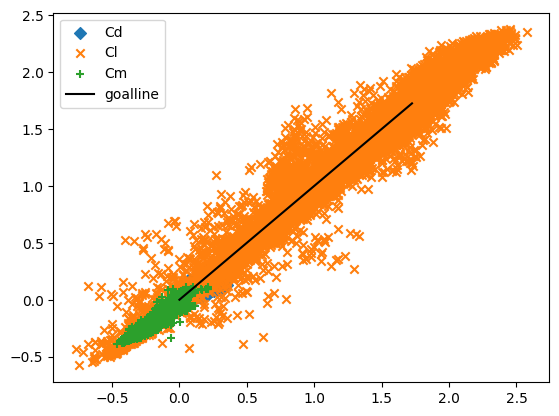

In [25]:
plt.scatter(collector_dict['actual']['test'][:,0].cpu().numpy(), collector_dict['preds']['test'][:,0].cpu().numpy(), marker='D', label= 'Cd')
plt.scatter(collector_dict['actual']['test'][:,1].cpu().numpy(), collector_dict['preds']['test'][:,1].cpu().numpy(), marker='x', label= 'Cl')
plt.scatter(collector_dict['actual']['test'][:,2].cpu().numpy(), collector_dict['preds']['test'][:,2].cpu().numpy(), marker='+', label= 'Cm')
plt.plot(np.arange(17250)/10000, np.arange(17250)/10000, color='k', label='goalline')
plt.legend()
plt.show()
